# Метод переменных направлений для уравнения:
\begin{cases}
(2-x)^2\dfrac{\partial u}{\partial t} = \dfrac{\partial}{\partial x}\left((2-x)^2\dfrac{\partial u}{\partial x}\right)+(2-x)^2\dfrac{\partial^2 u}{\partial y^2} + 
(2-x)\left[2(1-x)+2t\dfrac{\sin\pi x}{\pi}\dfrac{\cosh\pi y}{\sinh 2\pi}\right],\ x\in (0,1),\ y\in (0,2), t \gt 0 \\
u\rvert_{t=0}=\dfrac{\sin 2\pi x}{2-x}, \\
u\rvert_{x=0}=t, \quad u\rvert_{x=1}=0, \\
\dfrac{\partial u}{\partial y}\bigg\rvert_{y=0}=0, \quad \dfrac{\partial u}{\partial y}\bigg\rvert_{y=2}=t^2\dfrac{\sin\pi x}{2-x}.
\end{cases}

In [1]:
# аналитическое решение
u(x,y,t) = 1/(2-x)*(exp(-4pi^2*t)*sin(2pi*x) + t^2*sin(pi*x)/pi*cosh(pi*y)/sinh(2pi) + 2*t*(1-x))

u (generic function with 1 method)

In [55]:
lx, ly = 1, 2
r = 2
N, M = 10*r, 10*r

hx, hy = lx/N, ly/(M-1)

x =     0:hx:lx
y = -hy/2:hy:ly+hy/2

T = 0.1
J = 10*r          # число временных интервалов
tau = T/J       # шаг по времени
J += 1    # число временных слоев

t = 0:tau:T

0.0:0.005:0.1

In [56]:
function thomas_alg(A, B, C, F)
    N = length(A)
    K = zeros(Float64, N+1)
    E = zeros(Float64, N+1)

    for i = 1:N
        K[i+1] = -C[i]/(B[i] + A[i]*K[i])
        E[i+1] = (F[i] - A[i]*E[i])/(B[i] + A[i]*K[i])
    end

    x = zeros(Float64, N+1)
    for i = N:-1:1
        x[i] = K[i+1]*x[i+1] + E[i+1]
    end

    return x[1:N]
end

thomas_alg (generic function with 1 method)

In [85]:
U = Array{Float64,3}(undef,J,N+1,M+1)

# правая часть
f(x,y,t) = 1/(2-x) * (2*(1-x) + 2*t*sin(pi*x)/pi*cosh(pi*y)/sinh(2pi))

# начальное условие
U[1,:,:] .= [sin(2pi*x[n])/(2-x[n]) for n=1:N+1, m=1:M+1]

for j = 1:J-1
    w = Array{Float64,2}(undef,N+1,M+1)
    
    for m = 2:M
        A = (1/hx .+ 1/2 ./ (2 .- x[2:end-1])).^2
        C = (1/hx .- 1/2 ./ (2 .- x[2:end-1])).^2
        B = -(A + C .+ 2/tau)
        F = -( f.(x[2:end-1],y[m],t[j]+tau/2) +
            1/hy^2*U[j,2:end-1,m-1] + (2/tau-2/hy^2)*U[j,2:end-1,m] + 1/hy^2*U[j,2:end-1,m+1] )
        
        F[1] -= (t[j] + tau/2)*A[1]
        A[1] = C[end] = 0
        
        w[2:end-1,m] .= thomas_alg(A,B,C,F)
    end
    w[1,:] .= t[j] + tau/2
    w[end,:] .= 0
    
    for n = 2:N
        A = 1/hy^2 * ones(M+1)
        B = -(2/tau+2/hy^2) * ones(M+1)
        C = copy(A)
        F = -( f.(x[n], y, t[j]+tau/2)  +
             (1/hx + 1/2 / (2 - x[n]))^2 * w[n-1,:] - 
             (2/hx^2 + 1/2 / (2 - x[n])^2 - 2/tau) * w[n,:] +
             (1/hx - 1/2 / (2 - x[n]))^2 * w[n+1,:] )
        
        A[1] = 0;    B[1] = 1;     C[1] = -1;    F[1] = 0
        A[end] = 1;  B[end] = -1;  C[end] = 0;   F[end] = -hy*t[j+1]^2*sin(pi*x[n])/(2-x[n])

        U[j+1,n,:] = thomas_alg(A,B,C,F)
    end
    U[j+1,1,:] .= t[j+1]
    U[j+1,end,:] .= 0
end

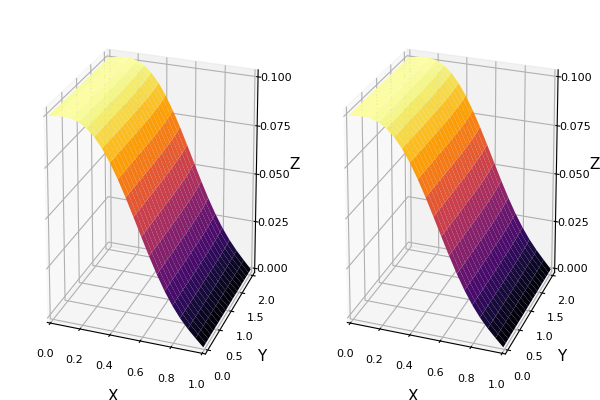

In [86]:
using Plots
pyplot()

j = J
Plots.plot(
    Plots.surface(x,y,U[j,:,:]',leg=false,xlabel="X",ylabel="Y",zlabel="Z"),
    Plots.surface(x,y,(x,y)->u(x,y,t[j]),leg=false,xlabel="X",ylabel="Y",zlabel="Z"),
    layout=2, camera=(20,20)
)

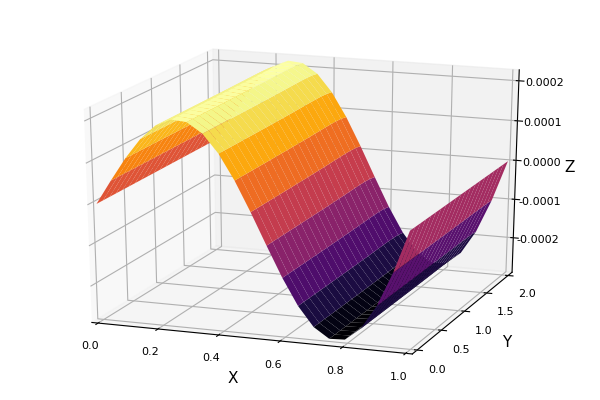

In [87]:
error = U[j,:,:] - [u(x[n],y[m],t[j]) for n=1:N+1,m=1:M+1]
Plots.surface(x,y,error',leg=false,xlabel="X",ylabel="Y",zlabel="Z",camera=(20,20))

# Схема Кранка-Николсона

In [79]:
U = Array{Float64,3}(undef,J,N+1,M+1)

# правая часть
f(x,y,t) = 1/(2-x) * (2*(1-x) + 2*t*sin(pi*x)/pi*cosh(pi*y)/sinh(2pi))

# начальное условие
U[1,:,:] .= [sin(2pi*x[n])/(2-x[n]) for n=1:N+1, m=1:M+1]

using ProgressMeter
pr = Progress(J-1, 1)

for j = 1:J-1
    w = Array{Float64,2}(undef,N+1,M+1)
    
    for m = 2:M
        A = 1/hx^2 * ones(N-1)
        C = 1/hx^2 * ((2 .- x[3:end]) ./ (2 .- x[2:end-1])).^2
        B = -(A + C .+ 2/tau)
        F = -( f.(x[2:end-1],y[m],t[j]) + f.(x[2:end-1],y[m],t[j+1]) +
            A.*U[j,1:end-2,m] + (2/tau .- (A+C)).*U[j,2:end-1,m] + C.*U[j,3:end,m] +
            1/hy^2*(U[j,2:end-1,m-1] - 2*U[j,2:end-1,m] + U[j,2:end-1,m+1]) )
        
        F[1] -= (t[j]+tau)*A[1]
        A[1] = C[end] = 0
        
        w[2:end-1,m] .= thomas_alg(A,B,C,F)
    end
    w[1,:] .= t[j] + tau
    w[end,:] .= 0
    
    for n = 2:N
        A = 1/hy^2 * ones(M+1)
        B = -(2/tau+2/hy^2) * ones(M+1)
        C = 1/hy^2 * ones(M+1)
        F = -2/tau*w[n,:]
        
        A[1] = 0;    B[1] = 1;     C[1] = -1;    F[1] = 0
        A[end] = 1;  B[end] = -1;  C[end] = 0;   F[end] = -hy*(t[j+1]^2)*sin(pi*x[n])/(2-x[n])

        U[j+1,n,:] = thomas_alg(A,B,C,F)
    end
    U[j+1,1,:] .= t[j+1]
    U[j+1,end,:] .= 0
    
    next!(pr) # update progress bar
end

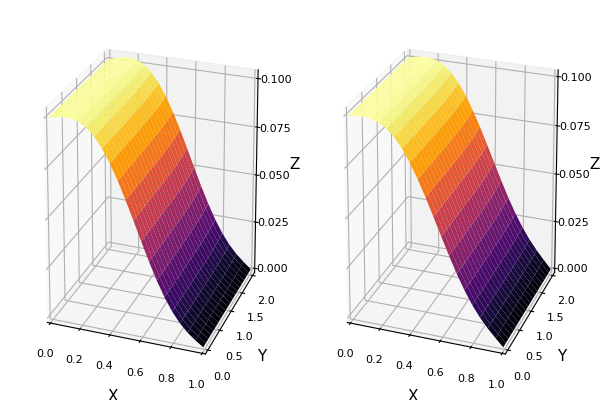

In [80]:
using Plots
pyplot()

j = J
Plots.plot(
    Plots.surface(x,y,U[j,:,:]',leg=false,xlabel="X",ylabel="Y",zlabel="Z"),
    Plots.surface(x,y,(x,y)->u(x,y,t[j]),leg=false,xlabel="X",ylabel="Y",zlabel="Z"),
    layout=2, camera=(20,20)
)

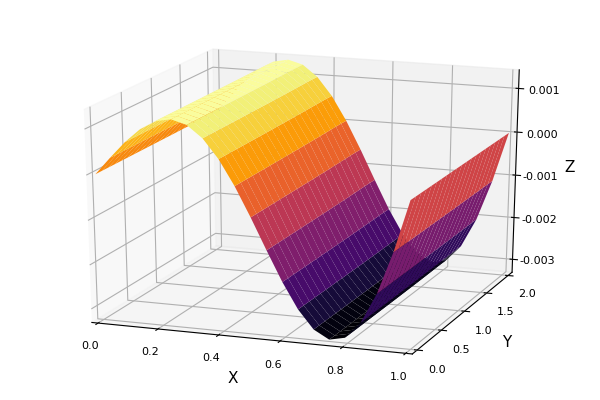

In [81]:
error = U[j,:,:] - [u(x[n],y[m],t[j]) for n=1:N+1,m=1:M+1]
Plots.surface(x,y,error',leg=false,xlabel="X",ylabel="Y",zlabel="Z",camera=(20,20))

## через $u_t$

In [82]:
U = Array{Float64,3}(undef,J,N+1,M+1)

# правая часть
f(x,y,t) = 1/(2-x) * (2*(1-x) + 2*t*sin(pi*x)/pi*cosh(pi*y)/sinh(2pi))

# начальное условие
U[1,:,:] .= [sin(2pi*x[n])/(2-x[n]) for n=1:N+1, m=1:M+1]

using ProgressMeter
pr = Progress(J-1, 1)

for j = 1:J-1
    w = Array{Float64,2}(undef,N+1,M+1)
    
    for m = 2:M
        A = 1/hx^2 * ones(N-1)
        C = 1/hx^2 * ((2 .- x[3:end]) ./ (2 .- x[2:end-1])).^2
        B = -(A + C .+ 2/tau)
        F = -2/tau*( (f.(x[2:end-1],y[m],t[j]) + f.(x[2:end-1],y[m],t[j+1]))/2 +
            A.*U[j,1:end-2,m] - (A + C).*U[j,2:end-1,m] + C.*U[j,3:end,m] +
            1/hy^2*(U[j,2:end-1,m-1] - 2*U[j,2:end-1,m] + U[j,2:end-1,m+1]) )
        
        F[1] -= A[1]
        A[1] = C[end] = 0
        
        w[2:end-1,m] .= thomas_alg(A,B,C,F)
    end
    w[1,:] .= 1
    w[end,:] .= 0
    
    for n = 2:N
        A = 1/hy^2 * ones(M+1)
        B = -(2/tau+2/hy^2) * ones(M+1)
        C = 1/hy^2 * ones(M+1)
        F = zeros(M+1)
        F[2:end-1] = A[2:end-1].*U[j,n,1:end-2] + B[2:end-1].*U[j,n,2:end-1] +
                     C[2:end-1].*U[j,n,3:end] - 2*w[n,2:end-1]
        
        A[1] = 0;    B[1] = 1;     C[1] = -1;    F[1] = 0
        A[end] = 1;  B[end] = -1;  C[end] = 0;   F[end] = -hy*t[j+1]^2*sin(pi*x[n])/(2-x[n])

        U[j+1,n,:] = thomas_alg(A,B,C,F)
    end
    U[j+1,1,:] .= t[j+1]
    U[j+1,end,:] .= 0
    
    next!(pr) # update progress bar
end

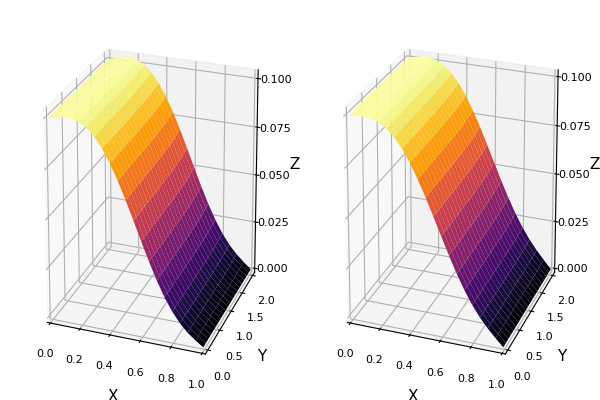

In [83]:
using Plots
pyplot()

j = J
Plots.plot(
    Plots.surface(x,y,U[j,:,:]',leg=false,xlabel="X",ylabel="Y",zlabel="Z"),
    Plots.surface(x,y,(x,y)->u(x,y,t[j]),leg=false,xlabel="X",ylabel="Y",zlabel="Z"),
    layout=2, camera=(20,20)
)

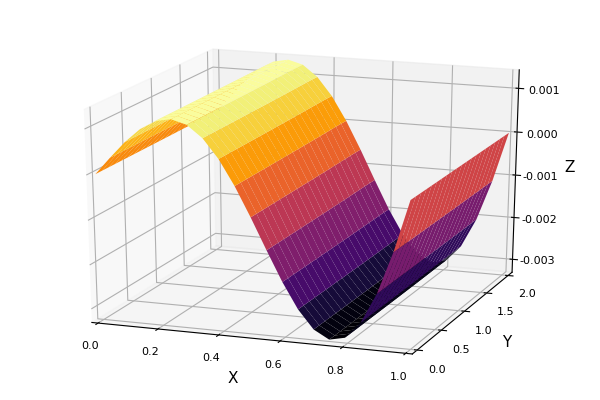

In [84]:
error = U[j,:,:] - [u(x[n],y[m],t[j]) for n=1:N+1,m=1:M+1]
Plots.surface(x,y,error',leg=false,xlabel="X",ylabel="Y",zlabel="Z",camera=(20,20))